<a href="https://colab.research.google.com/github/pulseq/Ankara-UMRAM-Hands-on-Course--March-2024/blob/main/tutorials/Ankara_SplitGREsequence4demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Write your first GRE sequence

This jupyter notebook is a walkthrough to construct a Gradient Recalled Echo (GRE) pulse sequence

1. First, import pyPulseq directly from github. No worries, in the initial execution the first cell may stop reporting an unknown error. This is because the environment needs to be restarted after replacing the module. Please re-run this cell and continue or redo "run all".

In [1]:
try:
  import pypulseq as mr
  print("pypulseq package is readily available\n")

except ImportError or ModuleNotFoundError:
  !pip install git+https://github.com/imr-framework/pypulseq.git

!pip show MRzeroCore || pip install MRzeroCore
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/util.py &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
#import utils # several helper functions for simulation and recon
import MRzeroCore as mr0


  Cloning https://github.com/imr-framework/pypulseq.git to /tmp/pip-req-build-zsho6r4j
  Running command git clone --filter=blob:none --quiet https://github.com/imr-framework/pypulseq.git /tmp/pip-req-build-zsho6r4j
  Resolved https://github.com/imr-framework/pypulseq.git to commit 20cce84c00fa8ffd637685a44746e0910b655edd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 10.5 MB/s eta 0:00:00
  Created wheel for pypulseq: filename=pypulseq-1.4.0-py3-none-any.whl size=269735 sha256=e3e1f6e1339ae98a3de311de7df5ef01afc11615f42747fc0549d5c444f80d94
  Stored in directory: /tmp/pip-ephem-wheel-cache-w6hncz1g/wheels/b3/3c/2d/4615def3ba2cf9a2c9b356df4563e66a9893931bf1c566339f
Successfully built pypulseq
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.2/347.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


In [2]:
import math
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as mr


2. Construct a `Sequence` object. A `Sequence` object is analogous to a pulse sequence. The following steps will demonstrate creating pulse sequence events and adding them to this `Sequence` object. The MR scanner's hardware limits are defined in an `Opts` object. All parameters are expected in SI units (meters, seconds, etc.)

In [3]:
sys = mr.Opts(max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s', rf_ringdown_time=20e-6, rf_dead_time=100e-6,
           adc_dead_time=10e-6)

seq = mr.Sequence(system=sys)
fov = 256e-3 # field of view (in meters)
Nx = 32 # number of frequency encode points
Ny = 32 # number of phase encode steps
alpha = 10 # RF flip angle   (here in degrees, we convert it later to radians)
slice_thickness = 3e-3 #     (in meters)
TE = 10e-3 # echo time       (in seconds)
TR = 30e-3 # repetition time (in seconds)

rf_spoiling_inc = 117 # phase increment to implement the so-called RF spoiling, needed to achieve T1-weighted contrast

3. Now, construct the radio-frequency (RF), gradient, delay and ADC readout events.

In [4]:
rf, gz, gzr = mr.make_sinc_pulse(flip_angle=alpha * math.pi / 180, duration=4e-3, slice_thickness=slice_thickness,
                              time_bw_product=4, apodization=0.5, system=sys, return_gz=True) # "time_bw_product" defines the number of sidelobes of the sinc pulse (=> sharpness of the slice profile)
                                                                                              # "apodization" is needed to suppress out-of-slice excitation (so-called ringing)

delta_k = 1 / fov # the unit for k-space in Pulseq is 1/m

gx = mr.make_trapezoid(channel='x', flat_area=Nx * delta_k, flat_time=6.4e-3, system=sys)
adc = mr.make_adc(num_samples=Nx, duration=gx.flat_time, delay=gx.rise_time, system=sys)
gx_pre = mr.make_trapezoid(channel='x', area=-(gx.area+delta_k) / 2, duration=2e-3, system=sys)
gz_reph = mr.make_trapezoid(channel='z', area=-gz.area / 2, duration=2e-3, system=sys)
phase_areas = (np.arange(Ny) - Ny / 2) * delta_k

4. In subsequent parts  the `add_block()` function is used to add different event blocks to the sequence. All blocks are plotted using the `seq.plot()` funtion. The `plot()` command visualises the magnitude (strength) and phase (direction) of the RF events in the second and third panel.

a) Add RF and slice select gradient

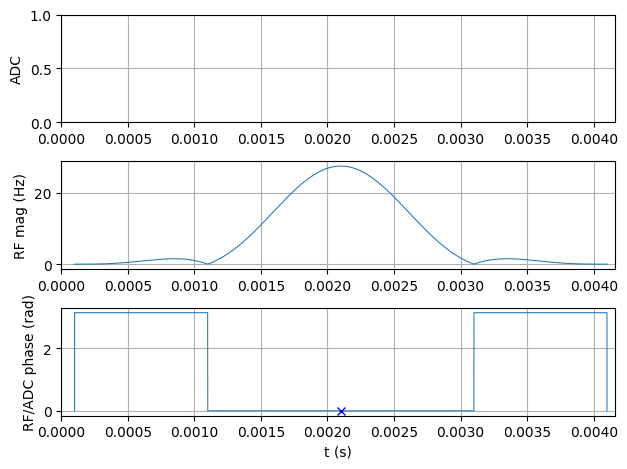

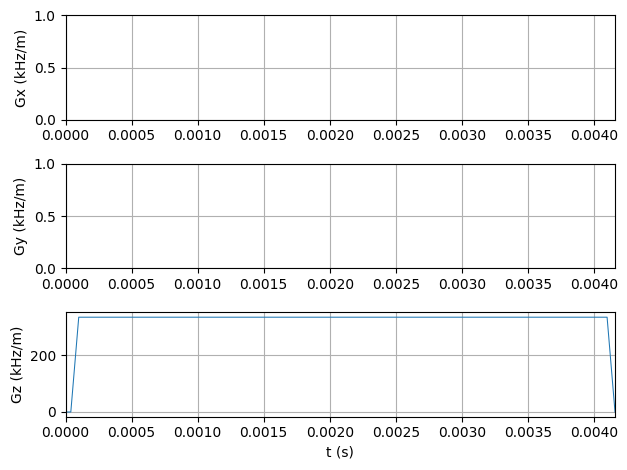

In [5]:
# initialize RF spoiling counters
rf_phase = 0
rf_inc = 0

# initialize data counters and flags needed for image reconstruction
seq.add_block(mr.make_label(label="REV", type="SET", value=1), # may be useful to correct for left-right swap in the image
              mr.make_label(type="SET", label="LIN", value=0)) # initialize the line counter (strictly speaking it is not needed because all counters are initialized to 0 automatically)

#for i in range(Ny): # We have Ny phase encodes
rf.phase_offset = rf_phase / 180 * np.pi
adc.phase_offset = rf_phase / 180 * np.pi
rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]
rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]

seq.add_block(rf, gz)

seq.plot() # plot added RF and slice select gradient

b) The phase encoding prephase is defined (`gy_pre`) and added in combination with the frequency prephaser (`gx_pre`) and the slice rewinder (`gz_reph`).
The shapes of the gradient pulses along the three directions `x`, `y` and `z` are depicted in the lower three panels. Each gradient pulse is plotted in a distinct color.

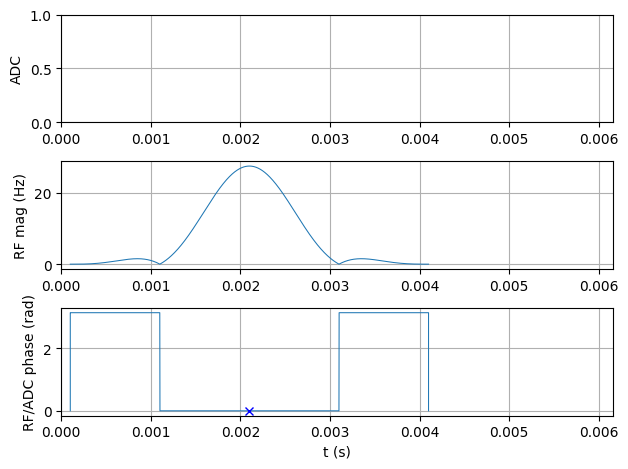

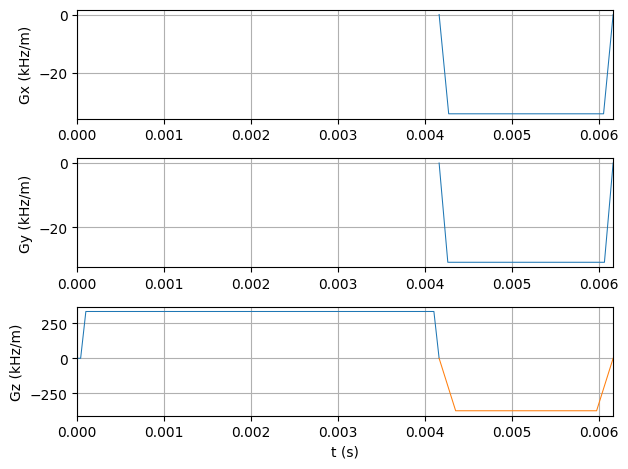

In [6]:
gy_pre = mr.make_trapezoid(channel='y', area=phase_areas[1], duration=2e-3, system=sys)
seq.add_block(gx_pre, gy_pre, gz_reph)

seq.plot()

c) Next we add a delay which defines our echo time `TE`. Initially, only the read-out or frequency encoding gradient `gx` is added in combination with the `adc` to acquire the data. The `adc` sampling points are plotted in the first panel. The echo time TE corresponds to the time interval between the center of the RF pulse and the central sampling point (9th point for an image of 16x16 pixels). Since the `RF` and `ADC` and gradient blocks have a finite time, the delay time `delay_TE` has to be calculated to ensure correct timing.

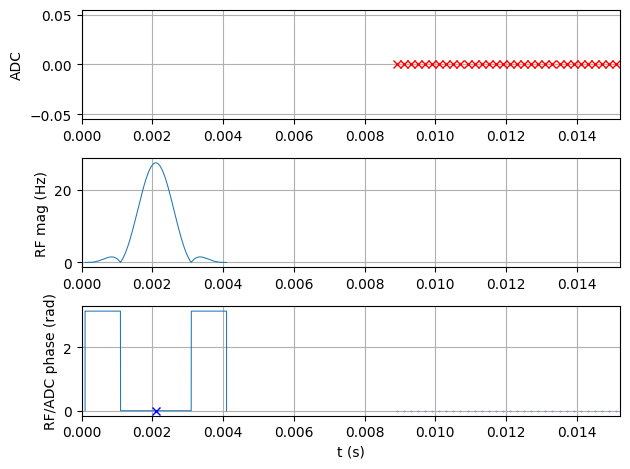

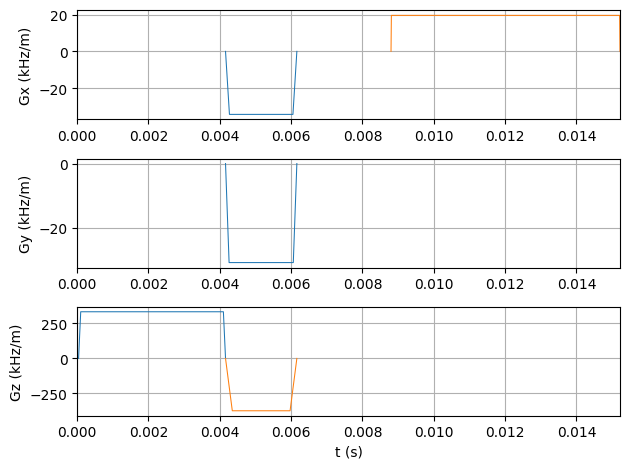

In [7]:
delay_TE = math.ceil((TE - gz.flat_time / 2 - gz.fall_time - mr.calc_duration(gx_pre) # TE contributions of the RF excitation, slice refocucing and readout prewinder
                      - adc.delay - adc.dwell*(Nx+1)/2 # TE contributions within the readout block (the echo should happen in the middle of the (N/2+1)-th dwell-time period)
                      ) / seq.grad_raster_time) * seq.grad_raster_time

seq.add_block(mr.make_delay(delay_TE))
seq.add_block(gx, adc)

seq.plot()

d) Before repeating all over, additional blocks are added now. These are the delay `TR`, defining the repetition time, a rephaser to undo the the prephasing in phase encoding direction created by `gy_pre` and spoilers along frequency encoding (`gx_spoil`) and slice (`gz_spoil`) directions. To achieve the correct repetition time, `TR`, we have to calculate the `delay_TR` to be added.

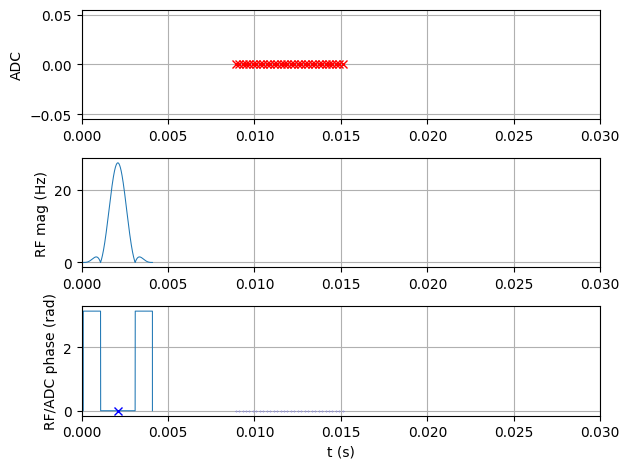

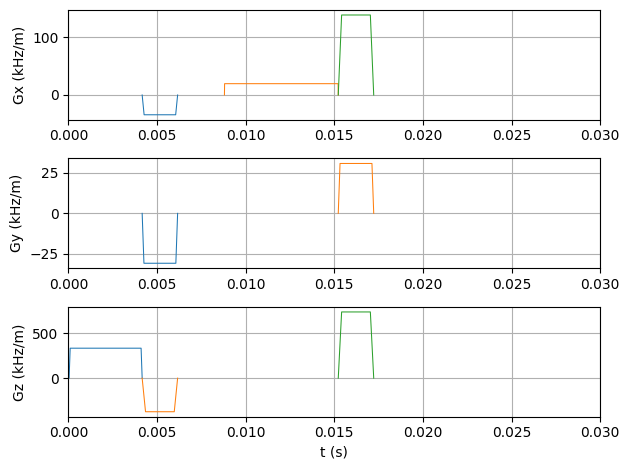

In [8]:
delay_TR = math.ceil((TR - mr.calc_duration(gx_pre) - mr.calc_duration(gz) - mr.calc_duration(
    gx) - delay_TE) / seq.grad_raster_time) * seq.grad_raster_time

gx_spoil = mr.make_trapezoid(channel='x', area=2 * Nx * delta_k, duration=2e-3, system=sys)     # define spoiler gradient along x
gz_spoil = mr.make_trapezoid(channel='z', area=4 / slice_thickness, duration=2e-3, system=sys)  # define spoiler gradient along z

seq.add_block(mr.make_delay(delay_TR),  # TR filling delay
              gx_spoil,                 # spoiler gradient along readout direction
              mr.scale_grad(gy_pre,-1), # phase-encoding rewinder gradient
              gz_spoil,                 # spoiler along slice-selection direction
              mr.make_label(type="INC", label="LIN", value=1)) # increment line counter (needed for image recon on the scanner)

seq.plot()

5. All aforementioned blocks need to be added in total `Ny` times, which is the number of phase encode steps. Because we have readily introduced the first phase encoding step manually, in this example we start the loop at 2. After the loop finishes the whole sequence is fully defined.

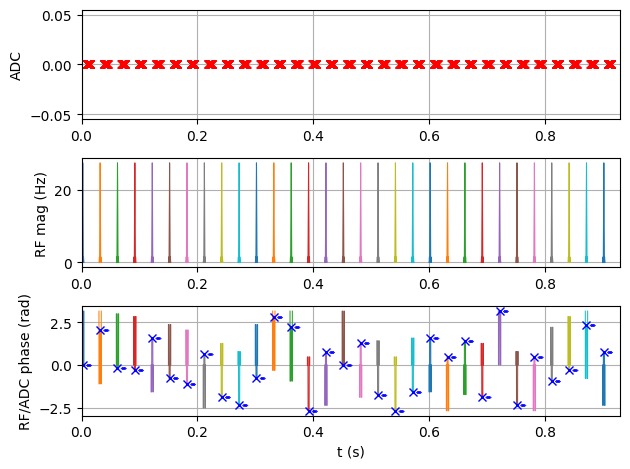

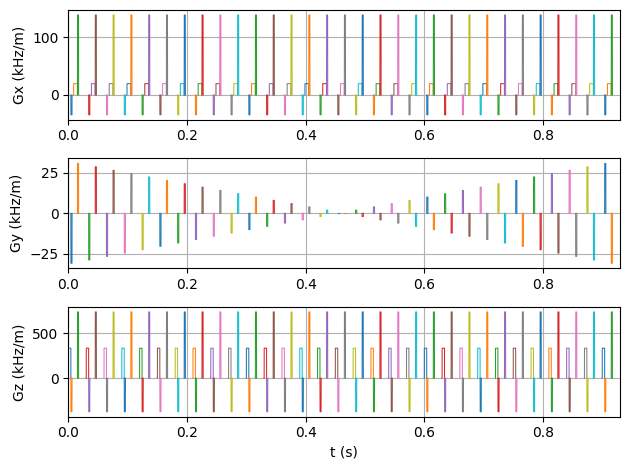

In [9]:
for i in range(2,Ny): # We have Ny phase encodes
    rf.phase_offset = rf_phase / 180 * np.pi
    adc.phase_offset = rf_phase / 180 * np.pi
    rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]
    rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]

    seq.add_block(rf, gz)
    gy_pre = mr.make_trapezoid(channel='y', area=phase_areas[i], duration=2e-3, system=sys)
    seq.add_block(gx_pre, gy_pre, gz_reph)
    seq.add_block(mr.make_delay(delay_TE))
    seq.add_block(gx, adc)
    seq.add_block(mr.make_delay(delay_TR), gx_spoil, mr.scale_grad(gy_pre,-1), gz_spoil, mr.make_label(type="INC", label="LIN", value=1))


seq.plot()

6. It is possible to plot only a fraction of the complete sequence. Adapt `nn` for the number of TRs you want to plot.

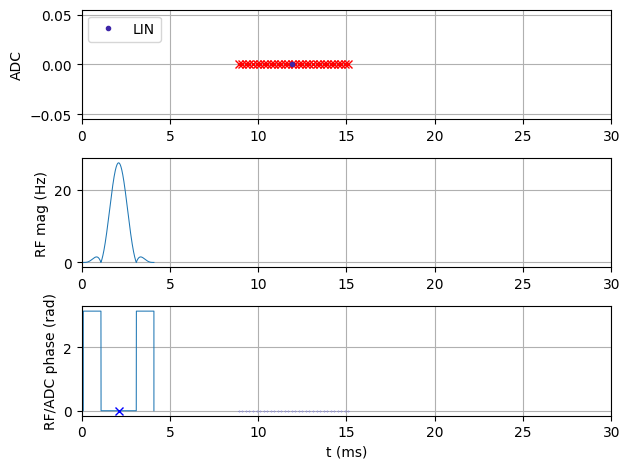

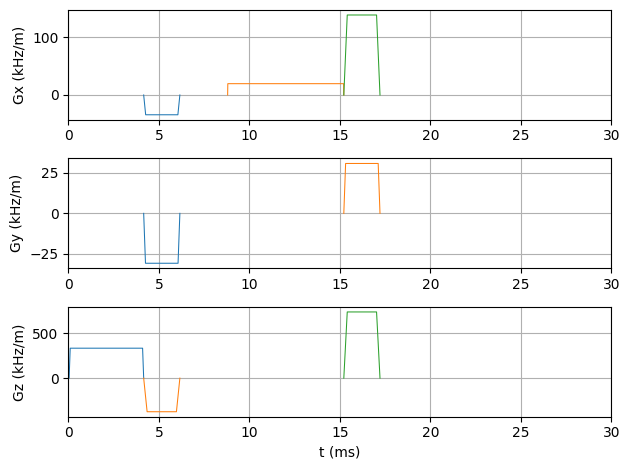

In [10]:
nn = 1
seq.plot(label="lin", time_range=np.array([0, nn])*TR, time_disp="ms") # plot nn number of TRs

7. To allow for simple changes, the whole sequence is combined here, again.
  Due to memory restrictions of this worksheet very larger cannot be achieved.

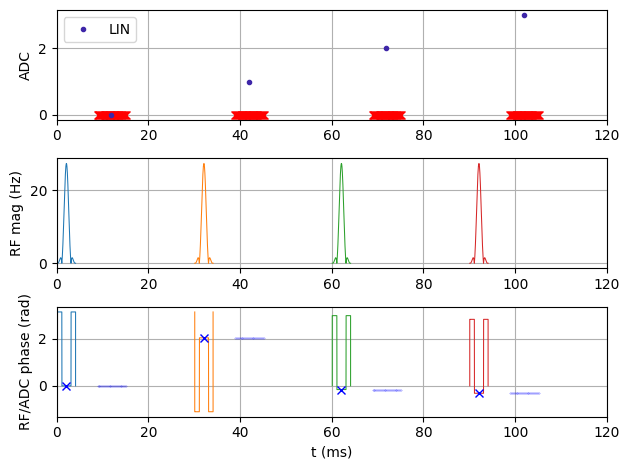

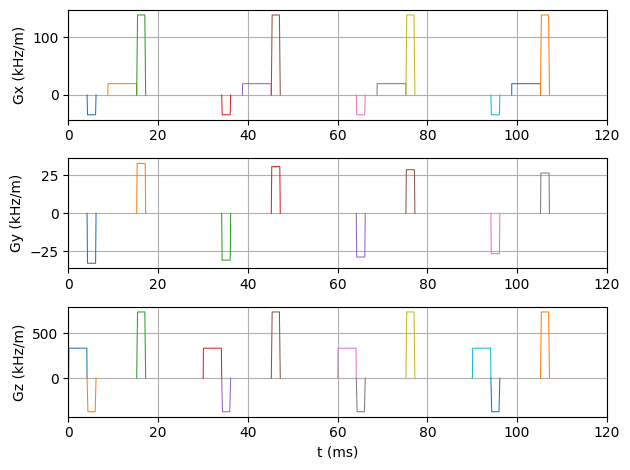

In [11]:
sys = mr.Opts(max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s', rf_ringdown_time=20e-6, rf_dead_time=100e-6,
           adc_dead_time=10e-6)
seq = mr.Sequence(system=sys)

fov = 256e-3 # field of view in m
Nx = 32 # number of frequency encodes
Ny = 32 # number of phase encodes
alpha = 10 # RF flip angle
slice_thickness = 3e-3
TE = 10e-3 # echo time
TR = 30e-3 # repetition time

rf_spoiling_inc = 117


rf, gz, gzr = mr.make_sinc_pulse(flip_angle=alpha * math.pi / 180, duration=4e-3, slice_thickness=slice_thickness,
                              apodization=0.5, time_bw_product=4, system=sys, return_gz=True)
delta_k = 1 / fov
gx = mr.make_trapezoid(channel='x', flat_area=Nx * delta_k, flat_time=6.4e-3, system=sys)
adc = mr.make_adc(num_samples=Nx, duration=gx.flat_time, delay=gx.rise_time, system=sys)
gx_pre = mr.make_trapezoid(channel='x', area=-(gx.area+delta_k) / 2, duration=2e-3, system=sys)
gz_reph = mr.make_trapezoid(channel='z', area=-gz.area / 2, duration=2e-3, system=sys)
phase_areas = (np.arange(Ny) - Ny / 2) * delta_k

gx_spoil = mr.make_trapezoid(channel='x', area=2 * Nx * delta_k, duration=2e-3, system=sys)
gz_spoil = mr.make_trapezoid(channel='z', area=4 / slice_thickness, duration=2e-3, system=sys)

delay_TE = math.ceil((TE - gz.flat_time / 2 - gz.fall_time - mr.calc_duration(gx_pre) # TE contributions of the RF excitation, slice refocucing and readout prewinder
                      - adc.delay - adc.dwell*(Nx+1)/2 # TE contributions within the readout block (the echo should happen in the middle of the (N/2+1)-th dwell-time period)
                      ) / seq.grad_raster_time) * seq.grad_raster_time
delay_TR = math.ceil((TR - mr.calc_duration(gx_pre) - mr.calc_duration(gz) - mr.calc_duration(
    gx) - delay_TE) / seq.grad_raster_time) * seq.grad_raster_time

assert np.all(delay_TR >= mr.calc_duration(gx_spoil, gz_spoil))

# initialize RF spoiling counters
rf_phase = 0
rf_inc = 0

# initialize data counters and flags needed for image reconstruction
seq.add_block(mr.make_label(label="REV", type="SET", value=1), # may be useful to correct for left-right swap in the image
              mr.make_label(type="SET", label="LIN", value=0)) # initialize the line counter (strictly speaking it is not needed because all counters are initialized to 0 automatically)

for i in range(Ny): # We have Ny phase encodes
    rf.phase_offset = rf_phase / 180 * np.pi
    adc.phase_offset = rf_phase / 180 * np.pi
    rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]
    rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]

    seq.add_block(rf, gz)
    gy_pre = mr.make_trapezoid(channel='y', area=phase_areas[i], duration=2e-3, system=sys)
    seq.add_block(gx_pre, gy_pre, gz_reph)
    seq.add_block(mr.make_delay(delay_TE))
    seq.add_block(gx, adc)
    seq.add_block(mr.make_delay(delay_TR), gx_spoil, mr.scale_grad(gy_pre,-1), gz_spoil, mr.make_label(type="INC", label="LIN", value=1))


nn = 4
seq.plot(label="lin", time_range=np.array([0, nn])*TR, time_disp="ms") # plot nn number of TRs


8. In addition we can calculate and visualize the corresponding k-Space. In this example the sampling points (ADCs) in k-space are shown in red. The blue trajectory depicts the actual trajectory induced by applying gradient pulses.

  Please be aware that very larger matrix sizes cannot be visualized within this worksheet.

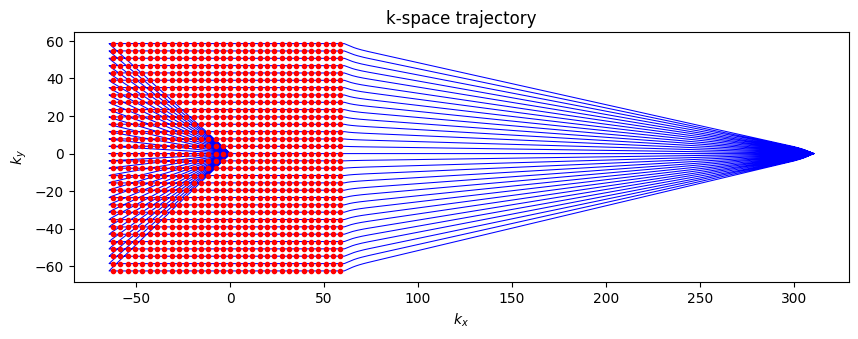

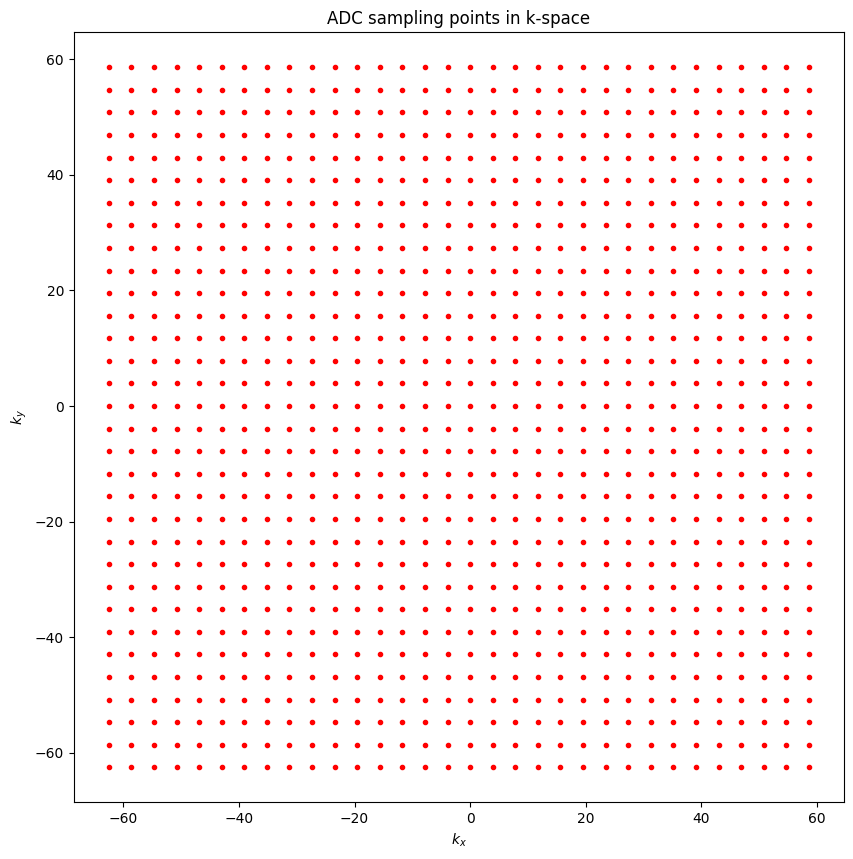

In [12]:
[k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc] = seq.calculate_kspace()
plt.figure(figsize=(10, 10))
plt.plot(k_traj[0,],k_traj[1,], 'b-')
plt.plot(k_traj_adc[0,],k_traj_adc[1,], 'r.')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.title('k-space trajectory')
plt.xlabel('$k_x$')
plt.ylabel('$k_y$')
plt.draw()


plt.figure(figsize=(10, 10))
plt.plot(k_traj_adc[0,],k_traj_adc[1,], 'r.')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.title('ADC sampling points in k-space')
plt.xlabel('$k_x$')
plt.ylabel('$k_y$')
plt.draw()

9. For the following tasks, please change the corresponding values in step ''7''. The resulting k-space can be plotted in step ''8''.


Tasks:
  
  a) Change the size of the field-of-view `fov`. How does the corresponding k-space change?
  
  b) Alter the resolution in frequency encoding direction `Nx`. How does the corresponding k-space change?
  
  c) Alter the resolution in phase encoding direction `Ny`. How does the corresponding k-space change?
  
  d) Which value,`Nx` or `Ny`, changes the total measurement time?

  e) Adapt the resolution to 64 x 64 and the field-of-view (fov) to 256e-3 for further simulations (step "7" and step "11").

  



10. a) (Optional) For exporting the pulse sequence as a `.seq` file, some more definitions are are optional for easier handling. The saved file can now be executed on different MRI scanners.
* You have to remove the `#` if you want to download your adapted sequence.


In [13]:
# last pre-flight checks: check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

seq.set_definition(key="Name", value="gre")
seq.set_definition(key="FOV", value=[fov, fov, slice_thickness])
seq.write('gre_pypulseq.seq')
from google.colab import files
# files.download('gre_pypulseq.seq')  # Download locally

Timing check passed successfully


10. b) (Optional) An additional test may be run to check basic sequence properties.

In [14]:
 # Very optional slow step, but useful for testing during development
 # e.g. for the real TE, TR or for staying within slew-rate limits, etc.
 rep = seq.test_report()
 print(rep)

Number of blocks: 161
Number of events:
RF:     32
Gx:     96
Gy:     64
Gz:     96
ADC:     32
Delay:      0
Sequence duration: 0.960000 s
TE: 0.010010 s
TR: 0.030000 s
Flip angle: 10.00 deg
Unique k-space positions (aka cols, rows, etc.): 32 32 
Dimensions: 2
Spatial resolution: 8.00 mm
Spatial resolution: 8.00 mm
Repetitions/slices/contrasts: 1.0; range: [(1.0, 1.0)]
Cartesian encoding trajectory detected
Event timing check passed successfully
Max gradient: 138122 32895 736648 Hz/m == 3.24 0.77 17.30 mT/m
Max slew rate: 1953125000 328947368 5555555556 Hz/m/s == 45.87 7.73 130.49 T/m/s
Max absolute gradient: 750207 Hz/m == 17.62 mT/m
Max absolute slew rate: 5.55555e+09 Hz/m/s == 130.49 T/m/s


11. The generated Pulseq sequence may now be used to simulate image acquisition and reconstruction. In the following steps a phantom is generated and an imaging experiment is simulated. The data is reconstructed using a FFT.

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


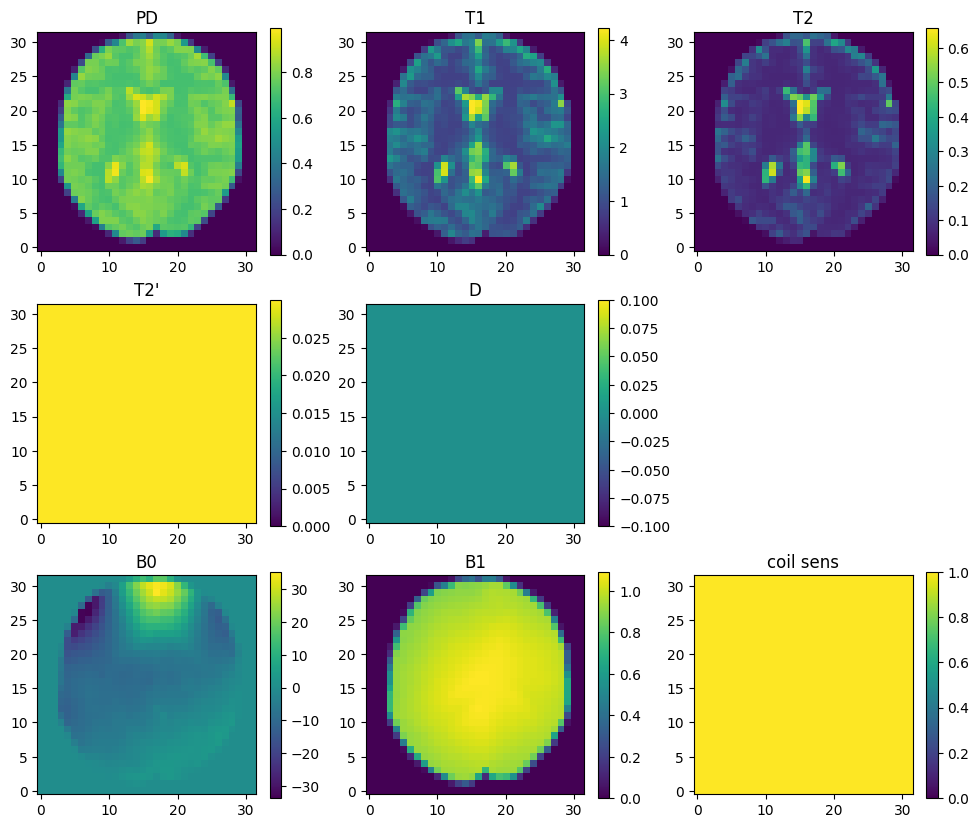

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/MRzeroCore/phantom/voxel_grid_phantom.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2 / self.size,


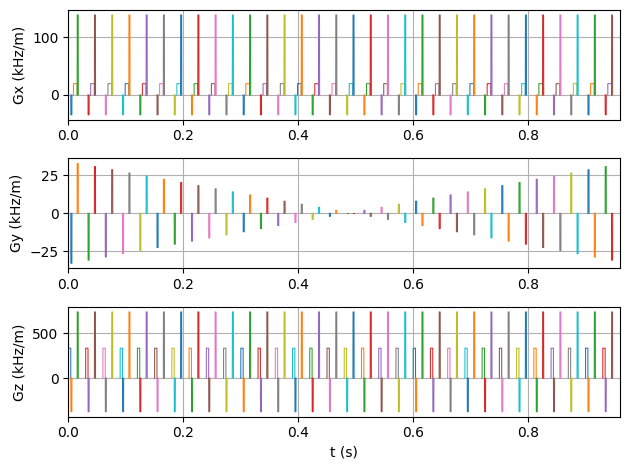

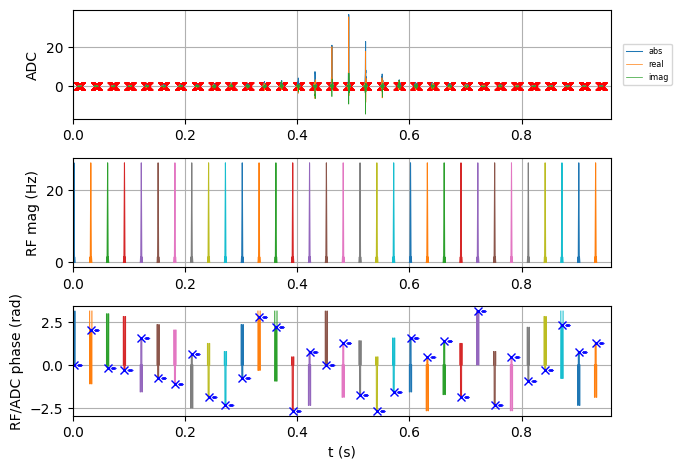

In [15]:
#@title Simulate seq file

dB0 = 0
sz = [32, 32]
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
# (i) load a phantom object from file
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p.T2dash[:] = 30e-3
obj_p.D *= 0
obj_p.B0 *= 1    # alter the B0 inhomogeneity
# Store PD and B0 for comparison
PD = obj_p.PD
B0 = obj_p.B0
# Manipulate loaded data
obj_p.B0+=dB0
obj_p.D*=0
obj_p.plot()
# Convert Phantom into simulation data
obj_p=obj_p.build()

# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file("gre_pypulseq.seq")
#seq0.plot_kspace_trajectory()
# Simulate the sequence
graph=mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal=mr0.execute_graph(graph, seq0, obj_p, print_progress=False)
# PLOT sequence with signal in the ADC subplot
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()



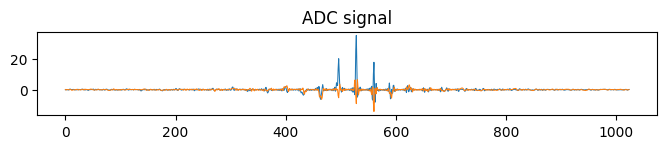

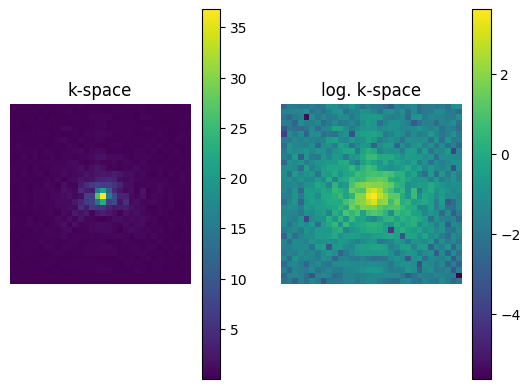

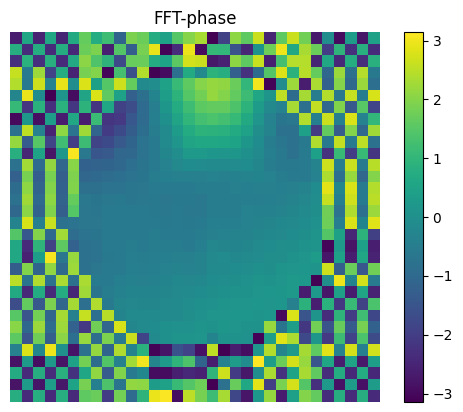

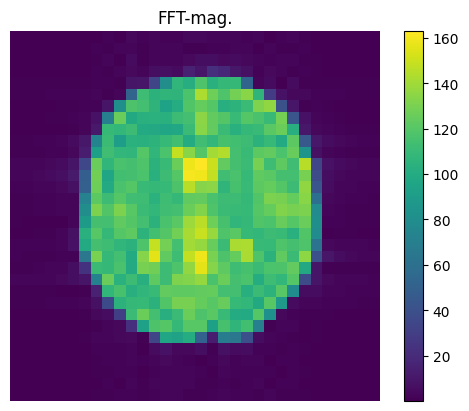

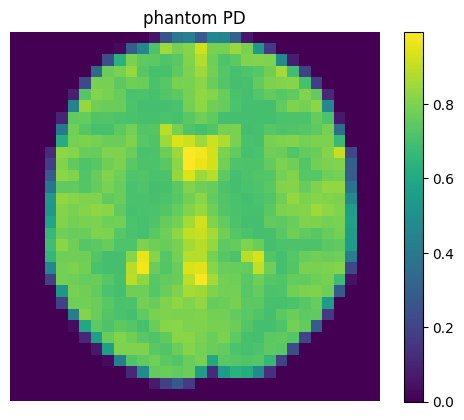

In [16]:
#@title 2D GRE in a brain phantom - reconstruction
# 2D FFT
def fft_2d(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x)))

kspace = np.reshape(signal, (Ny, Nx))
im = fft_2d(kspace)

fig = plt.figure(figsize=(8, 5))  # fig.clf()
plt.subplot(411)
plt.title('ADC signal')
plt.plot(np.real(signal), label='real')
plt.plot(np.imag(signal), label='imag')

plt.figure()
plt.subplot(121)
plt.title('k-space')
plt.imshow(np.abs(kspace)); plt.axis('off');plt.colorbar()
plt.subplot(122)
plt.title('log. k-space')
plt.imshow(np.log(np.abs(kspace))); plt.axis('off');plt.colorbar()
plt.figure()
plt.title('FFT-phase')
plt.imshow(np.angle(im), vmin=-np.pi, vmax=np.pi, origin="lower"); plt.axis('off')
plt.colorbar()
plt.figure()
plt.title('FFT-mag.')
plt.imshow(np.abs(im), origin="lower"); plt.axis('off');plt.colorbar()
plt.figure()
plt.title('phantom PD')
plt.imshow(PD.squeeze().T, origin="lower"); plt.axis('off');plt.colorbar()